In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from numpy.linalg import LinAlgError
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_glob = pd.read_csv('AirPassengers.csv')
df_glob.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# В данных нет пропусков
print(df_glob.columns)
df_glob.info()

Index(['Month', '#Passengers'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
df_glob['Month'] = pd.to_datetime(df_glob['Month'], format='%Y-%m')

In [5]:
display(df_glob.info())
df_glob.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


None

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [6]:
df_glob.set_index('Month', drop=True, inplace=True)
df_glob.index.is_monotonic_increasing
df = df_glob['1952':'1957'] 

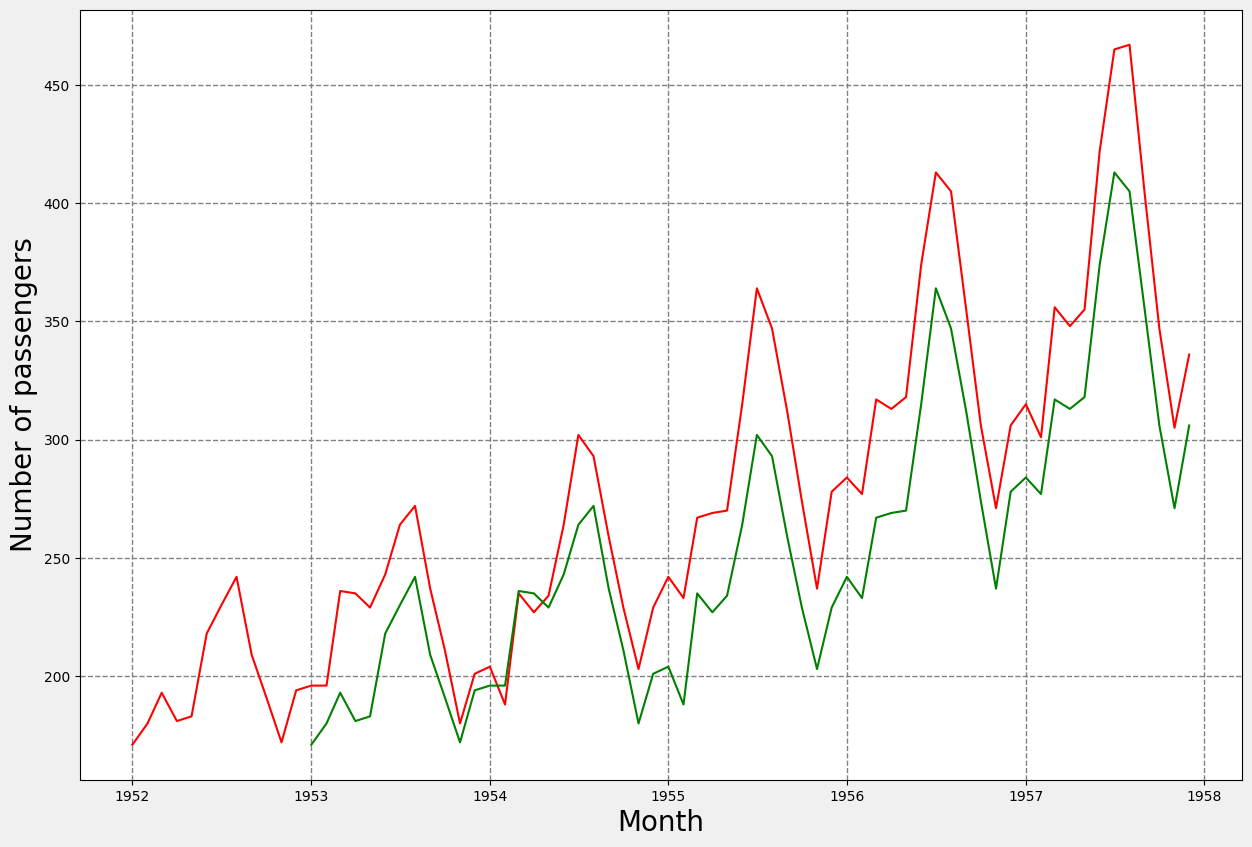

In [7]:
plt.figure(figsize=(15, 10), facecolor='#f0f0f0')
plt.plot(df, c='red')
plt.plot(df.shift(12), c='green')
plt.xlabel('Month', fontsize = 20)
plt.ylabel('Number of passengers', fontsize = 20)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.show()

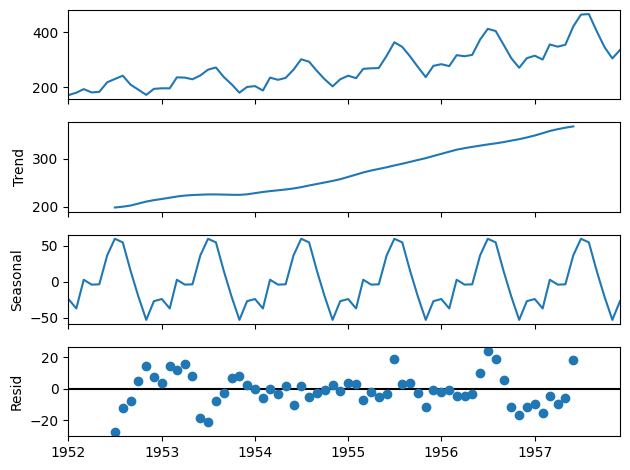

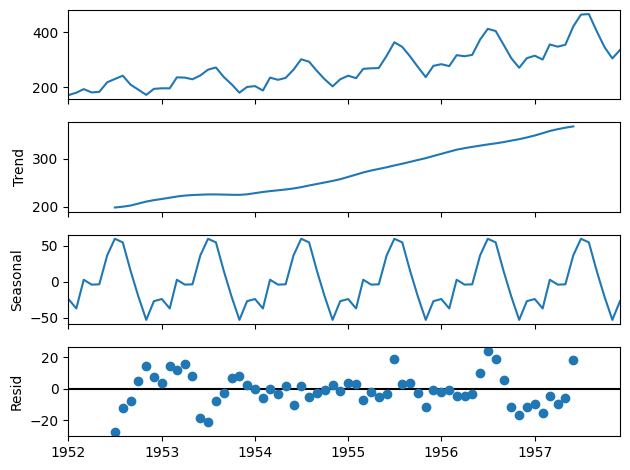

In [8]:
decomposed = seasonal_decompose(df)
decomposed.plot()

[Выводы дублируются из основного задания]

Наблюдается линейный тренд на увеличение и квартальная сезонность, первые три квартала наблюдается рост продаж, в последний -- падение.
Также имеется ярко выраженная годовая сезонность, стационарность отсутствует.  

In [9]:
SEED = 1

In [10]:
# Разделяем данные на валидационную и обучающую части

data_train, data_test = train_test_split(df, test_size=0.2, random_state=SEED, shuffle=False)


In [11]:
# Напишем функцию для визуализации прогнозных и фактических значений

def visualize_series(true_data, pred_data, title: str):
    
    plt.figure(figsize=(15, 10), facecolor='#f0f0f0')
    plt.plot(true_data, c='red', label = 'Actual_data')
    plt.plot(pred_data, c='green', label = 'Predicted_data')
    plt.xlabel('Month', fontsize = 20)
    plt.ylabel('Number of passengers', fontsize = 20)
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.legend(fontsize=15, borderpad=1.5)
    plt.title(title, fontsize=20)
    plt.show()

MAE модели AR(2): 32.12967670828466


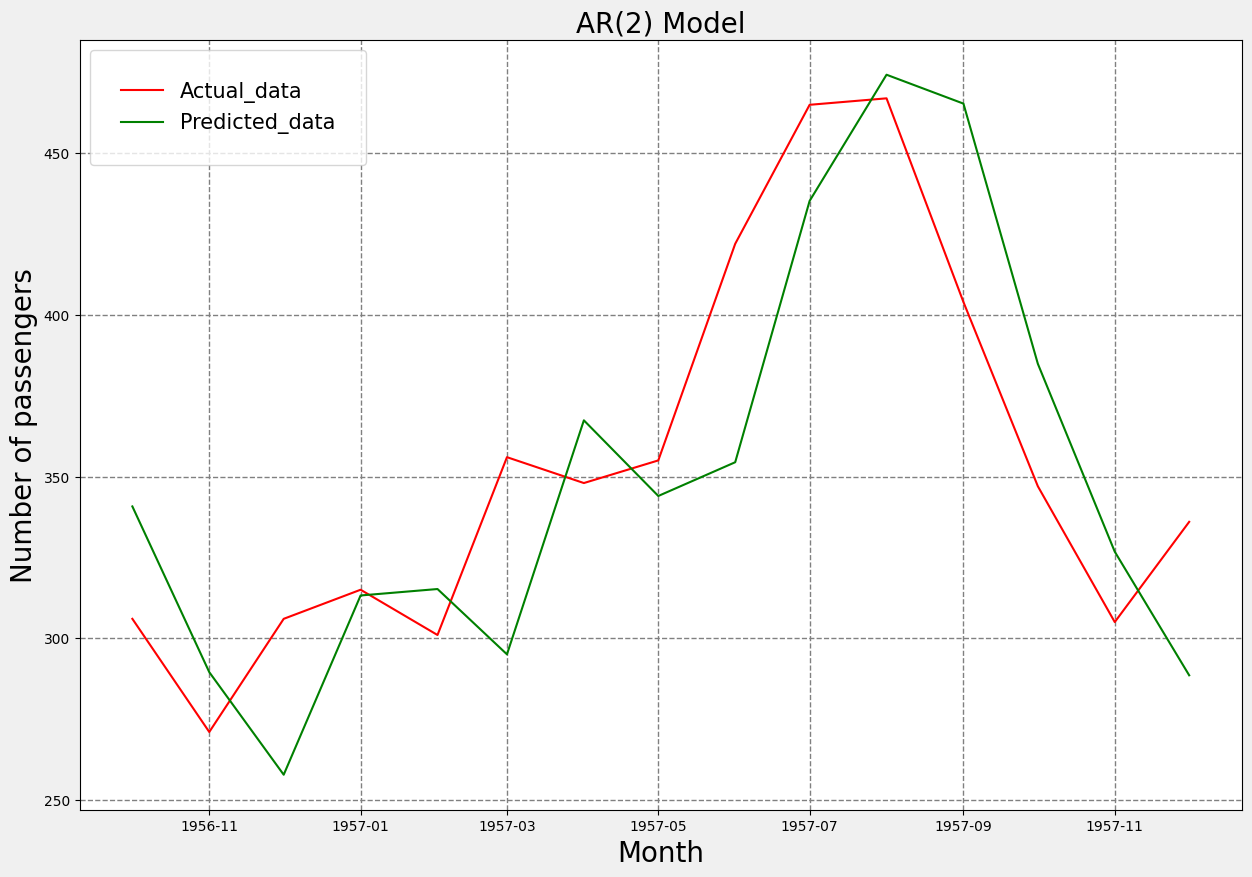

In [12]:
# AR-модель
# Лучшей по метрике MAE оказывается AR(2)

predictions = []
true_data = list(data_test['#Passengers'])
history = data_train.copy()

for i in range(data_test.shape[0]):
    
    model = SARIMAX(history, order=(2, 0, 0))
    model_fit = model.fit(disp = False)
    curr_pred = model_fit.forecast()
    predictions.append(curr_pred[0])
    history = pd.concat([history, data_test.iloc[i:i + 1]])
    # print(f'Predicted: {curr_pred[0]}, Actual: {true_data[i]}')

print(f'MAE модели AR(2): {mean_absolute_error(true_data, predictions)}')
visualize_series(true_data=data_test, pred_data=pd.Series(predictions, index=data_test.index), title = 'AR(2) Model')


В процессе перебора параметров возник вопрос -- почему модель AR(1) как будто даёт сдвинутые предсказания? (см. ниже)

MAE модели AR(1): 2.274925089872306


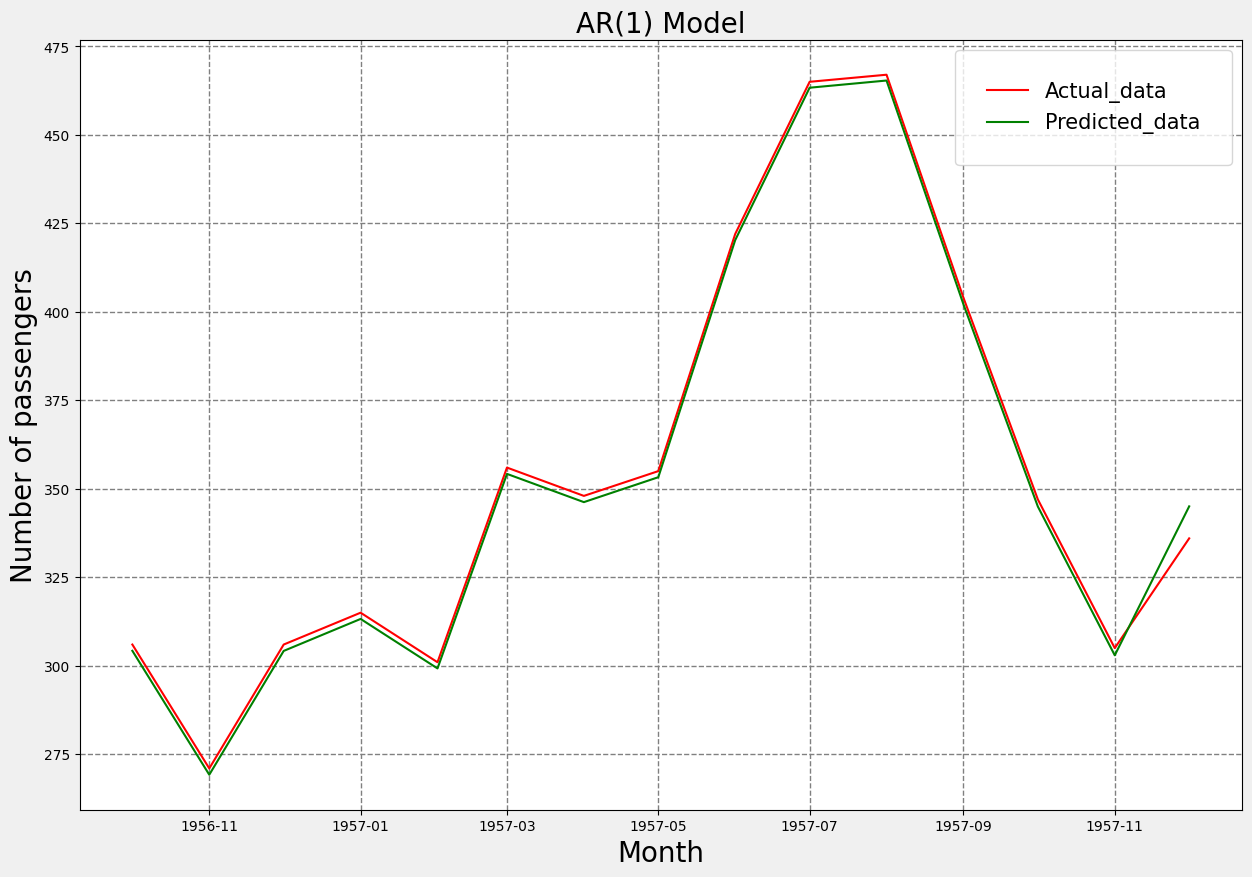

In [13]:
# Модель AR(1)

predictions = []
true_data = list(data_test['#Passengers'])
history = data_train.copy()

for i in range(data_test.shape[0]):
    
    model = SARIMAX(history, order=(1, 0, 0))
    model_fit = model.fit(disp = False)
    curr_pred = model_fit.forecast()
    predictions.append(curr_pred[0])
    history = pd.concat([history, data_test.iloc[i:i + 1]])
    # print(f'Predicted: {curr_pred[0]}, Actual: {true_data[i]}')

model = SARIMAX(history, order=(1, 1, 0))
model_fit = model.fit(disp = False)
curr_pred = model_fit.forecast()
predictions.append(curr_pred[0])

print(f'MAE модели AR(1): {mean_absolute_error(true_data, predictions[1:])}')
visualize_series(true_data=data_test, pred_data=pd.Series(predictions[1:], index=data_test.index), title='AR(1) Model')


In [14]:
# Для облегчения задачи построим нескольок вспомогательных функций


def tss_model(p: int, q: int, d = 0, P = 0, D = 0, Q = 0, s = 0, results = False):

    predictions = []
    true_data = list(data_test['#Passengers'])
    history = data_train.copy()

    for i in range(data_test.shape[0]):
        
        model = SARIMAX(history, order=(p, d, q), seasonal_order = (P, D, Q, s))
        model_fit = model.fit(disp = False)
        curr_pred = model_fit.forecast()
        predictions.append(curr_pred[0])
        history = pd.concat([history, data_test.iloc[i:i + 1]])

    if not results:
        return mean_absolute_error(true_data, predictions)
    else:
        return true_data, predictions

def visualize_model_results(p: int, q: int, title: str, d = 0, P = 0, D = 0, Q = 0, s = 0):
    results = tss_model(p, q, d, P, D, Q, s, results = True)
    visualize_series(results[0], results[1], title)    


In [15]:
lst = list()

for combination in itertools.product(range(1, 5), range(0, 5)):
    try:
        lst.append([combination, tss_model(combination[0], combination[1])])
    except LinAlgError:
      continue

min_MSE = min(lst, key = lambda x: x[1])
print(min_MSE)
print(lst)

[(3, 4), 23.415304127823955]
[[(1, 0), 34.5855276420168], [(1, 1), 31.43080265093686], [(1, 2), 33.316480065264656], [(1, 3), 36.29502948152181], [(1, 4), 29.208381135974893], [(2, 0), 32.12967670828466], [(2, 1), 31.336668813935937], [(2, 2), 31.120021176234093], [(2, 3), 32.04561717478074], [(2, 4), 29.989922355103015], [(3, 0), 32.58545616333729], [(3, 1), 31.158866398980766], [(3, 2), 30.311971665617303], [(3, 4), 23.415304127823955], [(4, 0), 32.98033177553609], [(4, 1), 31.842359254874545], [(4, 2), 29.65202142301503], [(4, 3), 26.747762822287203], [(4, 4), 23.969883329435934]]


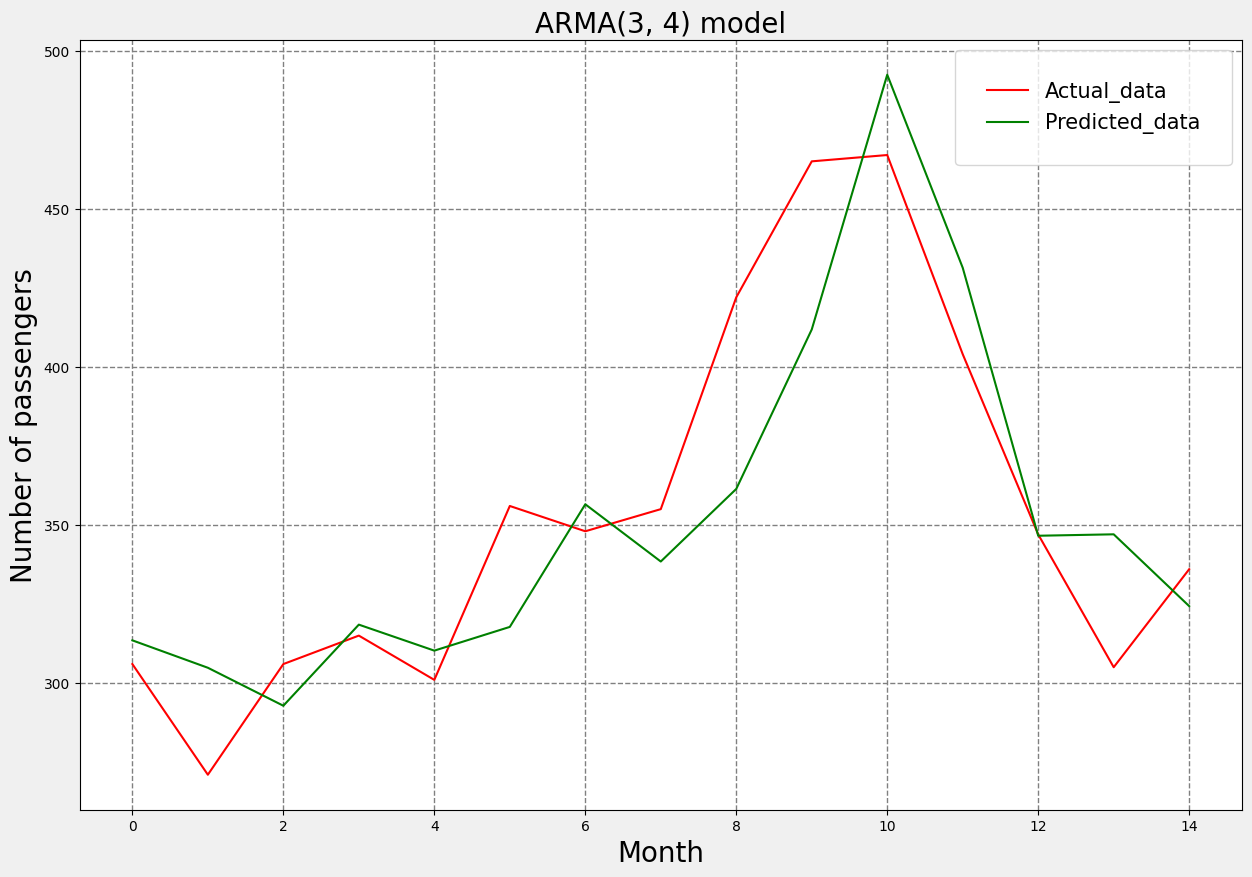

In [16]:
visualize_model_results(3, 4, title = 'ARMA(3, 4) model')

Лучшей моделью оказывается ARMA(3, 4). 
MAE = 23.4

In [17]:
# Подбираем лучшую модель ARIMA

lst = list()

for combination in itertools.product(range(1, 5), range(0, 5), range(0, 3)):
    try:
        lst.append([combination, tss_model(combination[0], combination[1], d = combination[2])])
    except LinAlgError:
      continue

min_MSE = min(lst, key = lambda x: x[1])
print(min_MSE)
print(lst)

[(3, 4, 0), 23.415304127823955]
[[(1, 0, 0), 34.5855276420168], [(1, 0, 1), 32.43597260538405], [(1, 0, 2), 36.359966386310724], [(1, 1, 0), 31.43080265093686], [(1, 1, 1), 31.706809090392586], [(1, 1, 2), 33.06202124750772], [(1, 2, 0), 33.316480065264656], [(1, 2, 1), 32.30557360994564], [(1, 2, 2), 32.125880256710765], [(1, 3, 0), 36.29502948152181], [(1, 3, 1), 32.17323916830178], [(1, 3, 2), 32.21258317169546], [(1, 4, 0), 29.208381135974893], [(1, 4, 1), 27.92168717830409], [(1, 4, 2), 33.11617667349995], [(2, 0, 0), 32.12967670828466], [(2, 0, 1), 32.72587067613182], [(2, 0, 2), 34.09677657886806], [(2, 1, 0), 31.336668813935937], [(2, 1, 1), 30.501992474768386], [(2, 1, 2), 33.317440531912055], [(2, 2, 0), 31.120021176234093], [(2, 2, 1), 30.887552464837018], [(2, 2, 2), 32.272663461781235], [(2, 3, 0), 32.04561717478074], [(2, 3, 1), 30.21407857682251], [(2, 3, 2), 32.409840757422465], [(2, 4, 0), 29.989922355103015], [(2, 4, 1), 27.794857423103476], [(2, 4, 2), 33.53732424908

In [18]:
lst = sorted(lst, key = lambda x: x[1])
lst

[[(3, 4, 0), 23.415304127823955],
 [(4, 4, 0), 23.969883329435934],
 [(4, 3, 1), 26.048504293546383],
 [(4, 4, 1), 26.240755090015963],
 [(4, 3, 0), 26.747762822287203],
 [(3, 3, 1), 26.955059318267065],
 [(2, 4, 1), 27.794857423103476],
 [(1, 4, 1), 27.92168717830409],
 [(4, 3, 2), 27.959008238832375],
 [(3, 3, 2), 28.701866956775714],
 [(1, 4, 0), 29.208381135974893],
 [(3, 2, 1), 29.26812497023341],
 [(4, 2, 0), 29.65202142301503],
 [(2, 4, 0), 29.989922355103015],
 [(2, 3, 1), 30.21407857682251],
 [(3, 4, 1), 30.23353001322504],
 [(3, 2, 0), 30.311971665617303],
 [(2, 1, 1), 30.501992474768386],
 [(2, 2, 1), 30.887552464837018],
 [(2, 2, 0), 31.120021176234093],
 [(3, 1, 0), 31.158866398980766],
 [(2, 1, 0), 31.336668813935937],
 [(4, 0, 1), 31.352408341531053],
 [(1, 1, 0), 31.43080265093686],
 [(1, 1, 1), 31.706809090392586],
 [(4, 1, 0), 31.842359254874545],
 [(4, 1, 2), 31.996516394055273],
 [(2, 3, 0), 32.04561717478074],
 [(1, 2, 2), 32.125880256710765],
 [(2, 0, 0), 32.12967

Лучшей моделью оказывается всё та же ARMA(3, 4) (ARIMA(3, 0, 4)) с d = 0.
MAE = 23.4.

Среди моделей с использованием параметра d лучшими являются (p, q, d):

(4, 4, 1)   26,2
(4, 3, 2)   28,0
(4, 3, 1)   26,0
(2, 4, 1)   27,8


Исследуем стационарность временного ряда и его производных с помощью статистического теста Дики-Фуллера. Видно, что вторая производная и далее являются стационарными. 


In [19]:
result = adfuller(data_train)
print(f'p-value for data_train in DF test is {result[1]}')

data_train_copy = data_train.copy()

for i in range(5):
    data_train_copy = data_train_copy.diff().dropna()
    result = adfuller(data_train_copy)
    print(f'p-value for {i + 1}th derivative is {result[1]}')

p-value for data_train in DF test is 1.0
p-value for 1th derivative is 0.41213594850751245
p-value for 2th derivative is 9.09120957962407e-09
p-value for 3th derivative is 1.0631042747237944e-12
p-value for 4th derivative is 5.098247408567175e-05
p-value for 5th derivative is 0.023061868011754683


Подберём теперь лучшую SARIMA-модель. Переберём руками параметры p, P, Q, D для небольших значений < 3, взяв при этом s = 12 и остальные значения равные нулю.

In [20]:

lst = []

for c in itertools.product(range(1, 3), range(0, 3), range(0, 3), range(0, 3)):
    try:
        lst.append([c, tss_model(p = c[0], q = 0, P = c[1], Q = c[2], D = c[3], s = 12)])
    except LinAlgError:
        continue

min_MSE = min(lst, key = lambda x: x[1])
print(min_MSE)
print(lst)

[(2, 1, 2, 2), 4.664366570895284]
[[(1, 0, 0, 0), 34.5855276420168], [(1, 0, 0, 1), 6.977959861402538], [(1, 0, 0, 2), 6.306674935163361], [(1, 0, 1, 0), 19.724682589585846], [(1, 0, 1, 1), 6.730103478673819], [(1, 0, 1, 2), 5.399469380091459], [(1, 0, 2, 0), 15.26953885938758], [(1, 0, 2, 1), 6.806107632056023], [(1, 0, 2, 2), 5.059604954536629], [(1, 1, 0, 0), 7.796323172633951], [(1, 1, 0, 1), 6.75213065174839], [(1, 1, 0, 2), 5.86256430819409], [(1, 1, 1, 0), 7.7124805672320536], [(1, 1, 1, 1), 6.756278406326552], [(1, 1, 1, 2), 5.095666501995565], [(1, 1, 2, 0), 7.76317444087905], [(1, 1, 2, 1), 6.908961421207005], [(1, 1, 2, 2), 5.038224665546867], [(1, 2, 0, 0), 7.683315346556814], [(1, 2, 0, 1), 6.865750315757892], [(1, 2, 0, 2), 5.485675982761374], [(1, 2, 1, 1), 7.000313061355663], [(1, 2, 1, 2), 5.151088011250052], [(1, 2, 2, 1), 7.278404481138466], [(1, 2, 2, 2), 6.903883681155306], [(2, 0, 0, 0), 32.12967670828466], [(2, 0, 0, 1), 7.057595778590257], [(2, 0, 0, 2), 6.19653

In [21]:
lst = sorted(lst, key = lambda x: x[1])
lst

[[(2, 1, 2, 2), 4.664366570895284],
 [(2, 1, 1, 2), 4.722441859379209],
 [(2, 0, 2, 2), 4.724402976567073],
 [(2, 0, 1, 2), 4.738162105050788],
 [(2, 2, 1, 2), 4.750910895819141],
 [(1, 1, 2, 2), 5.038224665546867],
 [(1, 0, 2, 2), 5.059604954536629],
 [(1, 1, 1, 2), 5.095666501995565],
 [(1, 2, 1, 2), 5.151088011250052],
 [(1, 0, 1, 2), 5.399469380091459],
 [(2, 2, 0, 2), 5.416989640972417],
 [(1, 2, 0, 2), 5.485675982761374],
 [(2, 1, 0, 2), 5.688261796312926],
 [(1, 1, 0, 2), 5.86256430819409],
 [(2, 0, 0, 2), 6.19653623082149],
 [(1, 0, 0, 2), 6.306674935163361],
 [(2, 2, 2, 2), 6.6130191392508895],
 [(2, 1, 1, 1), 6.682944405270746],
 [(1, 0, 1, 1), 6.730103478673819],
 [(1, 1, 0, 1), 6.75213065174839],
 [(1, 1, 1, 1), 6.756278406326552],
 [(2, 0, 1, 1), 6.790049466433895],
 [(2, 1, 0, 1), 6.802959458275571],
 [(1, 0, 2, 1), 6.806107632056023],
 [(2, 2, 1, 1), 6.856013419055656],
 [(1, 2, 0, 1), 6.865750315757892],
 [(1, 2, 2, 2), 6.903883681155306],
 [(1, 1, 2, 1), 6.908961421207

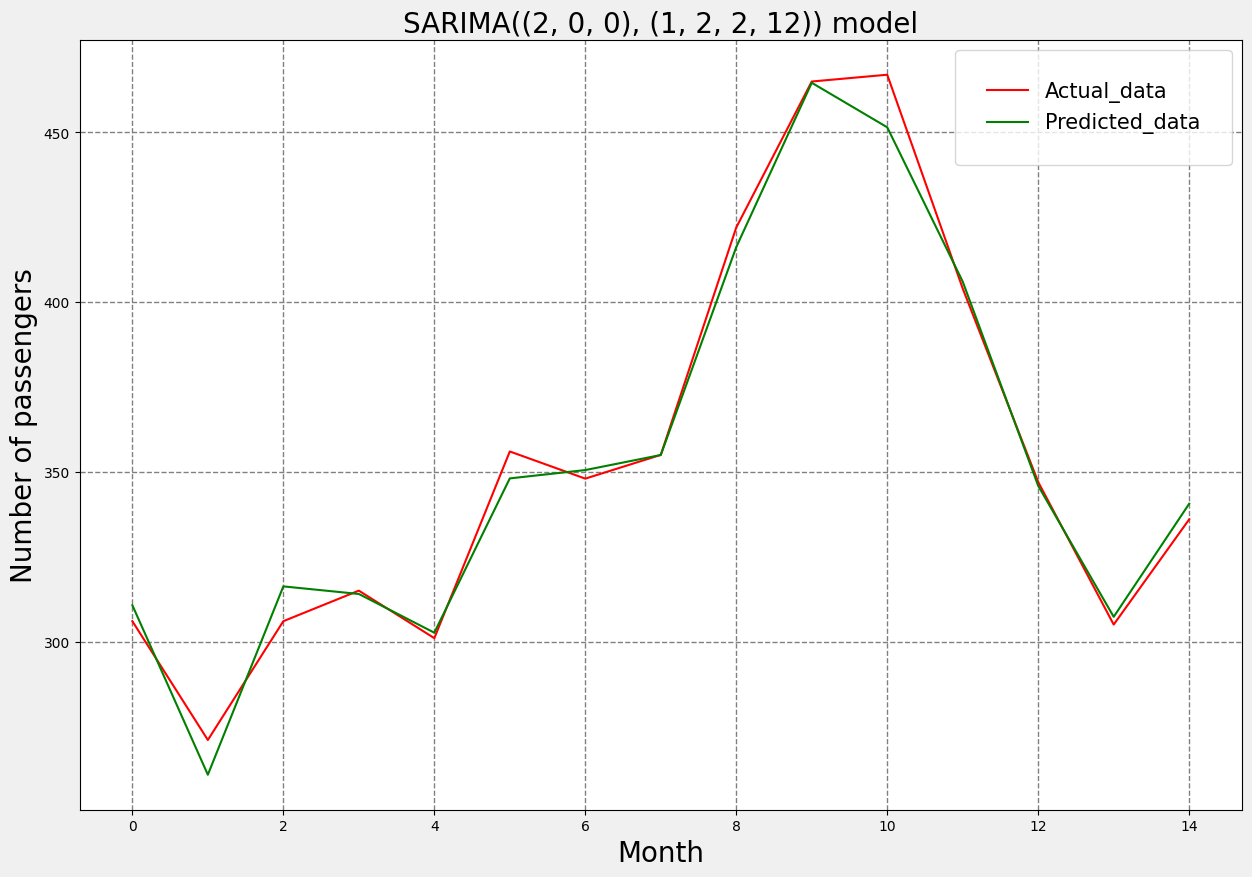

In [22]:
visualize_model_results(p = 2, q = 0, P = 1 , Q = 2,  D = 2, s = 12, title='SARIMA((2, 0, 0), (1, 2, 2, 12)) model')

Вывод:

1. Поскольку ряд является нестационарным, ожидать высоких результатов от AR или ARMA не приходится.
Результат модели AR(2) -- MAE = 32,1.
Лучший результат дала модель ARMA(3, 4) MAE = 23.4
2. Модель ARIMA не позволила улучшить результат, несмотря на то, что статистический тест Дики-Фуллера показал,
что ряд является 2-интегрированным.
3. Модель SARIMA, учитывающая сезонность, помогла добиться существенно лучшего результата. 
Наилучшая модель по метрике MAE имеет параметры (p, P, Q, D, s) = (2, 1, 2, 2, 12) с результатом
MAE = 4,6

при среднем значении таргета в целевой выборке 353,6.